In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
geno = pd.read_csv('alphasimr_output/test_sim_WF_1kbt_10000n_5000000bp_g.txt', index_col=0, sep=" ")
pheno = pd.read_csv('alphasimr_output/test_sim_WF_1kbt_10000n_5000000bp_p.txt', index_col=0, sep=" ")
eff = pd.read_csv('alphasimr_output/test_sim_WF_1kbt_10000n_5000000bp_eff.txt', sep=" ")


In [3]:
Z = geno.T.values
y = pheno.iloc[:, 9].values

lambda_grid = np.logspace(-3, 3, 50)  # Search over log scale


In [4]:
# Step 3: Train/Test Split (First 90% for training)
n_samples = Z.shape[0]
split_index = int(n_samples * 0.9)  # 90% of samples

Z_train, Z_test = Z[:split_index, :], Z[split_index:, :]
y_train, y_test = y[:split_index], y[split_index:]


In [5]:
# Compute mean allele frequency for each SNP
p = np.mean(Z_train, axis=0)

# Mean-center genotype matrices
Z_train_centered = Z_train - p
Z_test_centered = Z_test - p

lambda_grid = np.logspace(-3, 5, 50)  # Search over log scale


In [6]:
h2 = 0.4  # Example narrow-sense heritability
lambda_rrblup = (1 - h2) / h2  # Equivalent ridge penalty


In [7]:
#ridge_model = Ridge(alpha=lambda_rrblup)
#ridge_model.fit(Z_train_centered, y_train)


In [8]:
ridge_cv = RidgeCV(alphas=lambda_grid, store_cv_values=True)
ridge_cv.fit(Z_train_centered, y_train)
best_lambda = ridge_cv.alpha_  # Optimal lambda from cross-validation
print(best_lambda)

/opt/conda/envs/gpatlas/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


22229.96482526191


In [9]:
ridge_model = RidgeCV(alphas=[best_lambda])
#ridge_model = RidgeCV(alphas=150000)
ridge_model.fit(Z_train_centered, y_train)

RidgeCV(alphas=[22229.96482526191])

In [10]:
beta_hat = ridge_model.coef_
u_hat = Z_test_centered @ beta_hat


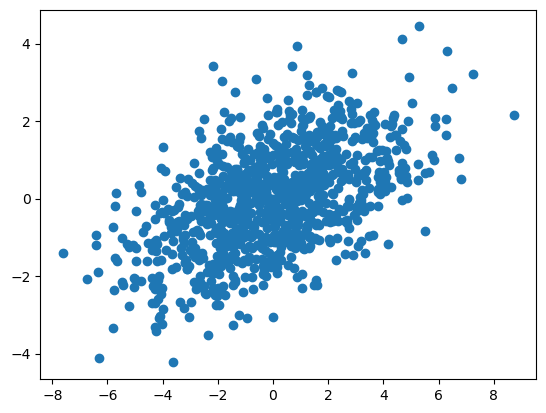

In [11]:
plt.scatter(y_test,u_hat)

In [12]:
from scipy import stats
stats.pearsonr(y_test,u_hat)

PearsonRResult(statistic=0.5274604029864074, pvalue=1.0583567426936733e-72)

In [18]:
eff

,locus,add_eff,epi_loc,epi_eff,sfs
trait,,,,,
1,1.0,0.0,6516.0,0.0,0.5168
1,2.0,0.0,5555.0,0.0,0.5168
1,3.0,0.0,5672.0,0.0,0.0016
1,4.0,0.0,1256.0,0.0,0.4879
1,5.0,0.0,7314.0,0.0,0.4879
...,...,...,...,...,...
25,99996.0,0.0,NaN,NaN,0.3100
25,99997.0,0.0,NaN,NaN,0.6900
25,99998.0,0.0,NaN,NaN,0.3100


In [27]:
ridge_model.coef_

eff_fit = eff[eff['trait'] == 10]
eff_fit

stats.pearsonr(eff_fit['add_eff'],ridge_model.coef_)

PearsonRResult(statistic=0.1108500291987821, pvalue=7.668239538662924e-271)